# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_tod/')


In [2]:
import pickle
from simulation import MultiTODSimulation
# Load the simulation data from a pickle file
with open('multi_tod_simulation_data.pkl', 'rb') as f:
    multi_tod_sim = pickle.load(f)

In [3]:
# Make all the individual variables available for backward compatibility
t_list = multi_tod_sim.t_list
theta_c_setting = multi_tod_sim.theta_c_setting
phi_c_setting = multi_tod_sim.phi_c_setting
theta_c_rising = multi_tod_sim.theta_c_rising
phi_c_rising = multi_tod_sim.phi_c_rising
bool_map_setting = multi_tod_sim.bool_map_setting
bool_map_rising = multi_tod_sim.bool_map_rising
integrated_beam_setting = multi_tod_sim.integrated_beam_setting
integrated_beam_rising = multi_tod_sim.integrated_beam_rising
full_bool_map = multi_tod_sim.full_bool_map
pixel_indices = multi_tod_sim.pixel_indices
integrated_beam = multi_tod_sim.integrated_beam
Tsky_operator_setting = multi_tod_sim.Tsky_operator_setting
Tsky_operator_rising = multi_tod_sim.Tsky_operator_rising
sky_params = multi_tod_sim.sky_params
ntime = multi_tod_sim.ntime
ndiode_proj = multi_tod_sim.ndiode_proj
nd_rec_operator = multi_tod_sim.nd_rec_operator
nd_rec_params = multi_tod_sim.nd_rec_params
gain_proj = multi_tod_sim.gain_proj
gain_params_setting = multi_tod_sim.gain_params_setting
gain_params_rising = multi_tod_sim.gain_params_rising
gains_setting = multi_tod_sim.gains_setting
gains_rising = multi_tod_sim.gains_rising
fc = multi_tod_sim.fc
logfc = multi_tod_sim.logfc
f0 = multi_tod_sim.f0
logf0 = multi_tod_sim.logf0
noise_setting = multi_tod_sim.noise_setting
noise_rising = multi_tod_sim.noise_rising
Tsys_setting = multi_tod_sim.Tsys_setting
Tsys_rising = multi_tod_sim.Tsys_rising
TOD_setting = multi_tod_sim.TOD_setting
TOD_rising = multi_tod_sim.TOD_rising
pixels_c_setting = multi_tod_sim.pixels_c_setting
bool_map_c_setting = multi_tod_sim.bool_map_c_setting
calibration_1_index = multi_tod_sim.calibration_1_index
calibration_5_indices = multi_tod_sim.calibration_5_indices

# Additional constants from the original code
T_ndiode = multi_tod_sim.T_ndiode
rec_params = multi_tod_sim.rec_params
dtime = multi_tod_sim.dtime
alpha = multi_tod_sim.alpha
logf0_list = [multi_tod_sim.logf0]
sigma_2 = multi_tod_sim.sigma_2

In [4]:
init_Tsys_params = np.hstack([sky_params, nd_rec_params, nd_rec_params])
init_noise_params = [logf0, alpha]


init_Tloc_params_list = [nd_rec_params, nd_rec_params]
init_Tsky_params = sky_params
init_noise_params_list = [init_noise_params, init_noise_params]

prior_std_frac = 0.1

# gain_prior_mean = gain_params_setting
# gain_prior_cov_inv = 1.0 / (prior_std_frac * gain_params_setting)**2  # Prior STD ~10%
# gain_prior_cov_inv[gain_prior_cov_inv > 100] = 100

Tsky_prior_cov_inv = 1. / (prior_std_frac * sky_params)**2
calibration_indices = calibration_5_indices
Tsky_prior_cov_inv[calibration_indices] = 1e20

aux = 1.0 / (nd_rec_params)**2  # Prior STD ~100%
aux[0] = 1.0
aux[1] = 1.0
Trec_prior_cov_inv_list = [aux, aux]

def log_prior_noise(params):
    _, alpha_est = params
    return -1e10 * (alpha_est - alpha)**4 

In [5]:
gain_prior_mean_setting = gain_params_setting
gain_prior_mean_rising = gain_params_rising

gain_prior_cov_inv_setting = 1.0 / (prior_std_frac * gain_params_setting)**2  # Prior STD ~10%
gain_prior_cov_inv_setting[gain_prior_cov_inv_setting > 100] = 100
gain_prior_cov_inv_rising = 1.0 / (prior_std_frac * gain_params_rising)**2  # Prior STD ~10%
gain_prior_cov_inv_rising[gain_prior_cov_inv_rising > 100] = 100

In [ ]:
# Import the FlickerCorrEmulator class first
from full_Gibbs_sampler import TOD_Gibbs_sampler

Tsys_samples, all_gain_samples, all_noise_samples = \
    TOD_Gibbs_sampler(
        [TOD_setting, TOD_rising],
        [t_list, t_list],
        [gain_proj, gain_proj],
        [Tsky_operator_setting, Tsky_operator_rising],
        [nd_rec_operator, nd_rec_operator],
        init_Tsky_params,
        init_Tloc_params_list,
        init_noise_params_list,
        [logfc, logfc],
        wnoise_var=2.5e-6,
        Tsky_prior_cov_inv=Tsky_prior_cov_inv,
        Tsky_prior_mean=sky_params,
        local_Tloc_prior_cov_inv_list=Trec_prior_cov_inv_list,
        local_Tloc_prior_mean_list=[nd_rec_params, nd_rec_params],
        local_gain_prior_cov_inv_list=[gain_prior_cov_inv_setting, gain_prior_cov_inv_rising],
        local_gain_prior_mean_list=[gain_prior_mean_setting, gain_prior_mean_rising],
        local_noise_prior_func_list=[None, None],
        joint_Tsys_sampling=True,
        smooth_gain_model="linear",
        noise_sampler_type="emcee",
        noise_Jeffreys_prior=False,
        n_samples=2000,
        tol=1e-20)

In [ ]:
# First, save the samples as npy files..

np.save("outputs/GS5_db/Tsys_samples_linearG.npy", Tsys_samples)
np.save("outputs/GS5_db/gain_samples_linearG.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/GS5_db/noise_samples_linearG.npy", np.concatenate(all_noise_samples, axis=0))


In [6]:
Tsys_samples = np.load("outputs/GS5_db/Tsys_samples_linearG.npy")
gain_samples = np.load("outputs/GS5_db/gain_samples_linearG.npy")
noise_samples = np.load("outputs/GS5_db/noise_samples_linearG.npy")


In [7]:
from MCMC_diagnostics import diagnostics

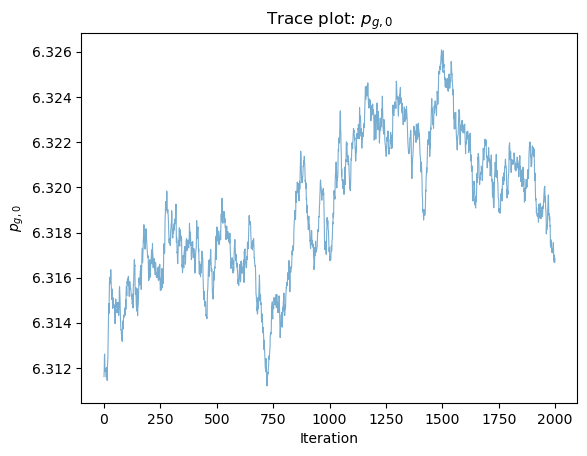

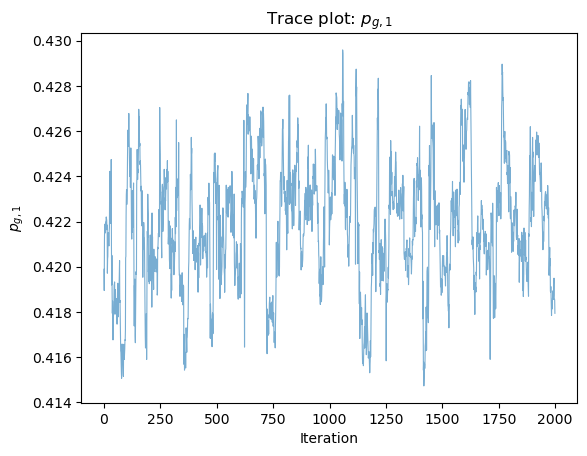

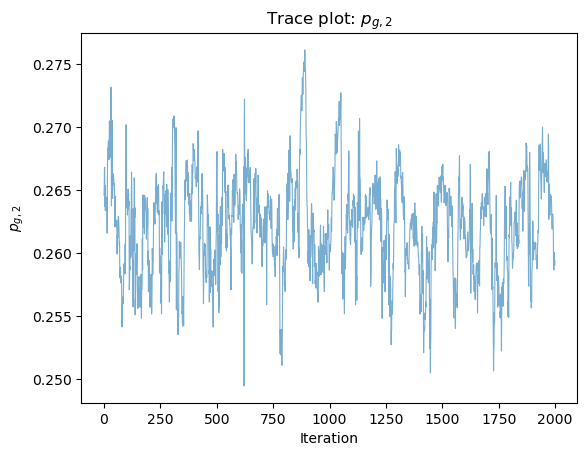

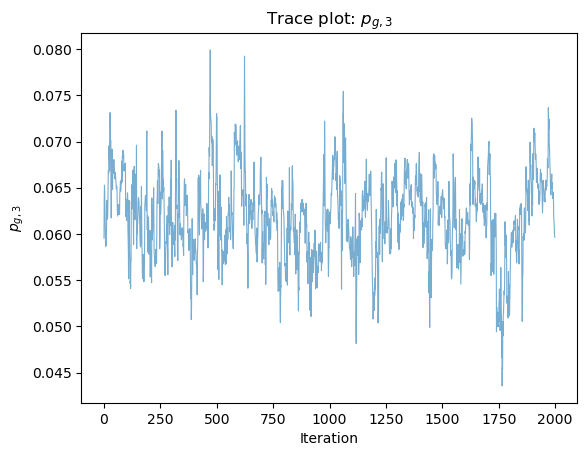

{'$p_{g,0}$': {'ESS_min': 3.8374229044446198,
  'ESS_median': 3.8374229044446198,
  'Rhat_split': 2.145670564915918},
 '$p_{g,1}$': {'ESS_min': 78.74197769181056,
  'ESS_median': 78.74197769181056,
  'Rhat_split': 1.0056099847687572},
 '$p_{g,2}$': {'ESS_min': 93.93075076395448,
  'ESS_median': 93.93075076395448,
  'Rhat_split': 1.0022798549311767},
 '$p_{g,3}$': {'ESS_min': 66.95192871289973,
  'ESS_median': 66.95192871289973,
  'Rhat_split': 0.9996716715077839}}

In [6]:
aux = gain_samples[0].reshape(1, 2000, 4)
diagnostics(aux, param_names=[r"$p_{g,0}$", r"$p_{g,1}$",r"$p_{g,2}$",r"$p_{g,3}$"], max_plots=5)

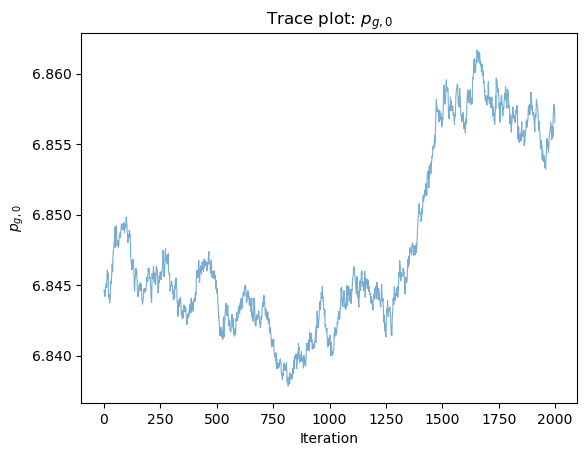

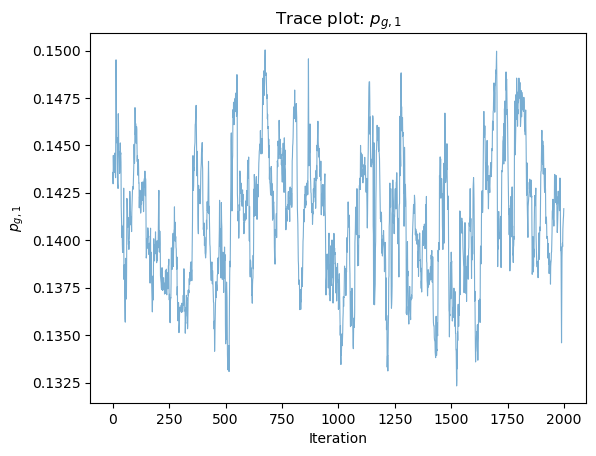

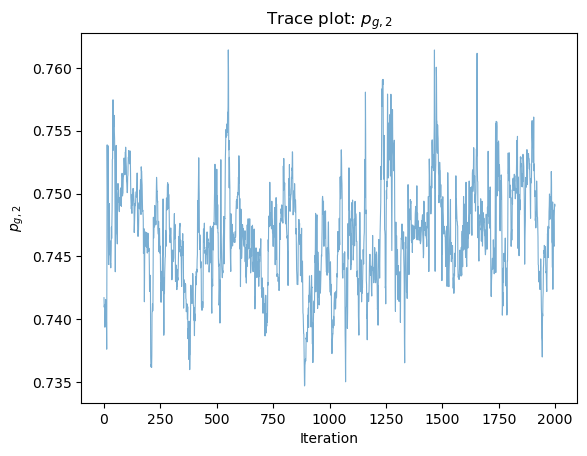

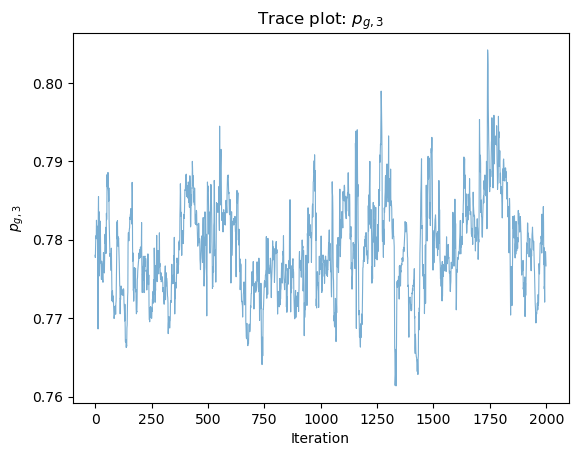

{'$p_{g,0}$': {'ESS_min': 3.3273165053510922,
  'ESS_median': 3.3273165053510922,
  'Rhat_split': 1.554273452927344},
 '$p_{g,1}$': {'ESS_min': 36.4746464497211,
  'ESS_median': 36.4746464497211,
  'Rhat_split': 1.001359013384458},
 '$p_{g,2}$': {'ESS_min': 55.49640891216227,
  'ESS_median': 55.49640891216227,
  'Rhat_split': 1.0237578201258921},
 '$p_{g,3}$': {'ESS_min': 29.910404107697655,
  'ESS_median': 29.910404107697655,
  'Rhat_split': 1.0584869841314086}}

In [7]:
aux = gain_samples[1].reshape(1, 2000, 4)
diagnostics(aux, param_names=[r"$p_{g,0}$", r"$p_{g,1}$",r"$p_{g,2}$",r"$p_{g,3}$"], max_plots=5)

292
All pixels - Mean: -0.0174, Std: 0.3076, RMS: 0.3081
All pixels - 16th-84th percentile: [-0.0421, 0.0723]
Internal pixels - Mean: 0.0022, Std: 0.2052, RMS: 0.2052
Internal pixels - 16th-84th percentile: [-0.0204, 0.0299]
Plot saved to: figures/new/GS5_db_mean_res.pdf


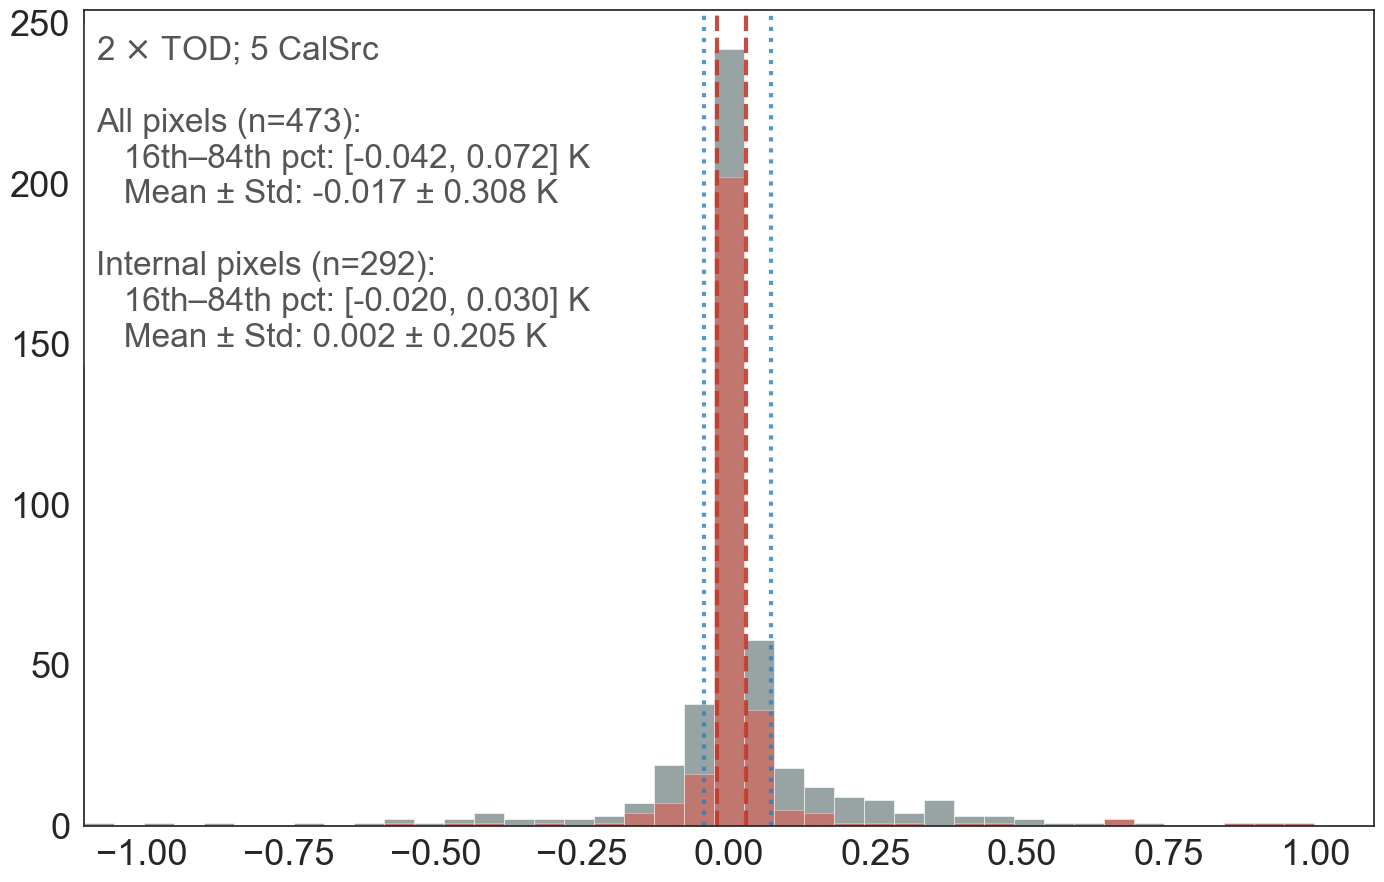

All pixels - Mean: -0.0182, Std: 0.3105, RMS: 0.3110
All pixels - 16th-84th percentile: [-0.0434, 0.0695]
Internal pixels - Mean: 0.0021, Std: 0.2071, RMS: 0.2071
Internal pixels - 16th-84th percentile: [-0.0203, 0.0299]
Plot saved to: figures/new/GS5_db_median_res.pdf


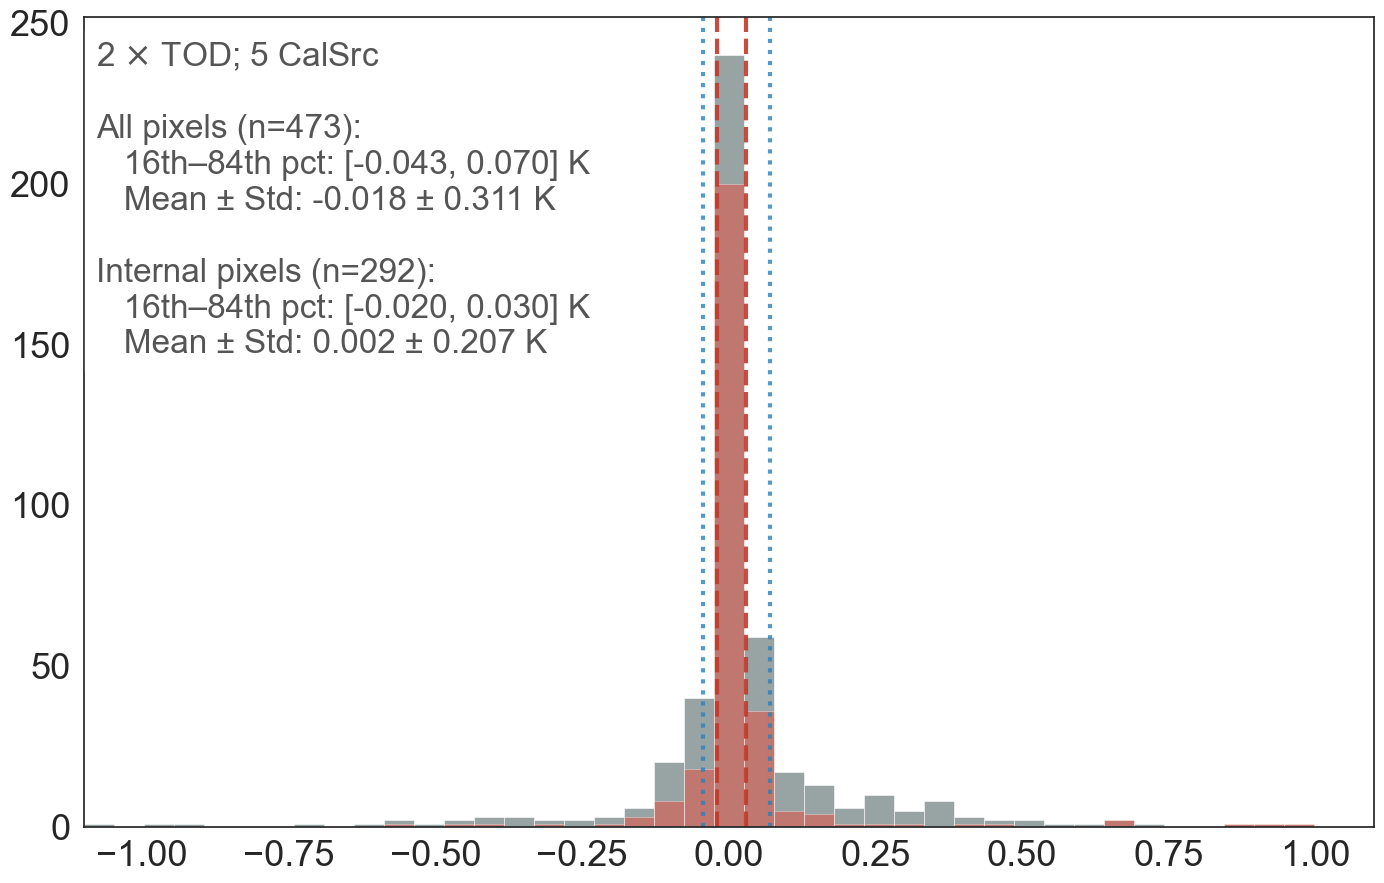

/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be in

{'mean': (array([ 8.48620702,  8.4187314 ,  8.42620947,  8.19350407,  8.05291628,
          7.90253701,  7.66304305,  7.32263925,  7.87524959,  7.00701193,
          8.43954734,  8.17683958,  8.89321513,  8.5022449 ,  8.98849374,
          8.11332506,  7.67510418,  8.62139229,  8.75215163,  7.76760676,
          8.33682066,  7.95012578,  8.88863631,  7.10429114,  7.33259943,
          7.1313063 ,  6.80315559,  7.74903765,  6.18425166,  6.11827888,
          6.3423177 ,  6.0243053 ,  4.93717717,  5.67931952,  5.65155607,
          5.80284559,  5.82713003,  8.6768581 ,  8.89921835,  8.69838507,
          8.57948698,  8.37589067,  9.04122098,  8.17123941,  7.8840274 ,
          7.86358879,  7.78817377,  8.06076091,  7.85695776,  7.62548784,
          6.9043063 ,  6.71759489,  6.99192596,  6.75406942,  6.44982433,
          6.33904761,  6.22971268,  6.0849719 ,  5.65299163,  5.93283408,
          5.60260164,  5.73794733,  6.0394882 ,  6.10123278,  8.50818746,
          9.25945989,  8.84451

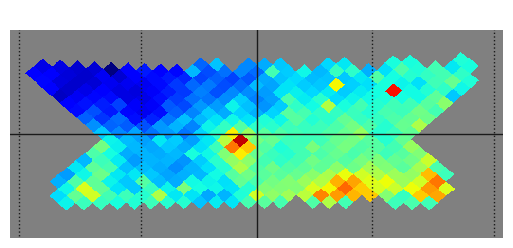

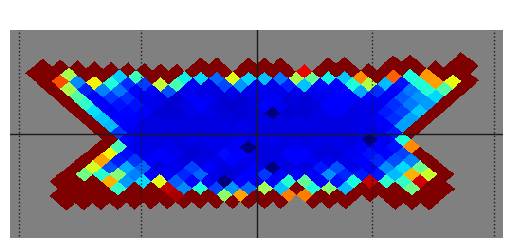

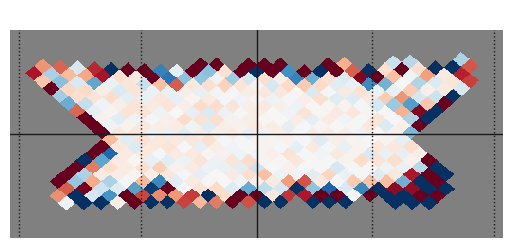

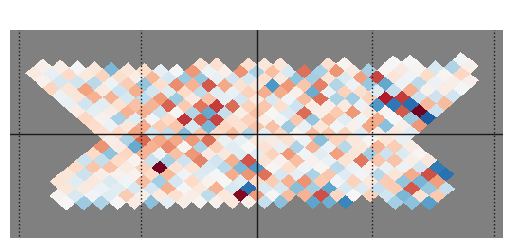

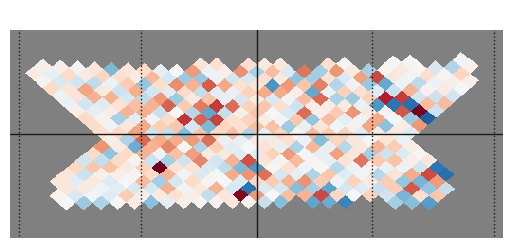

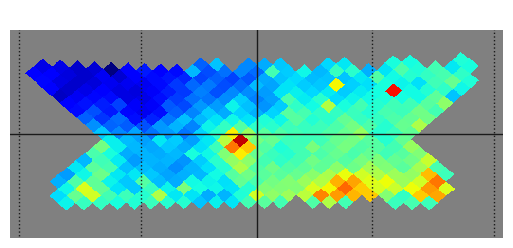

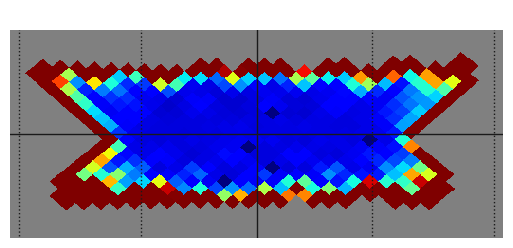

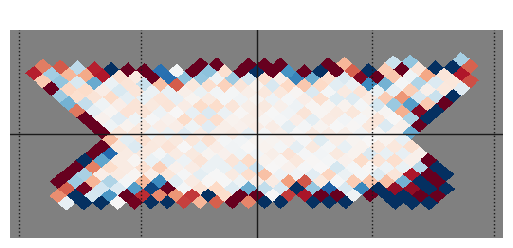

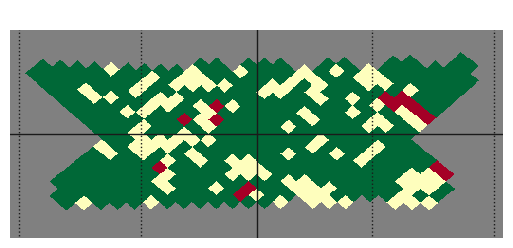

In [8]:
from simulation import TODSimulation, MultiTODSimulation

from analysis import explore_posterior_joint_Tsys

explore_posterior_joint_Tsys(Tsys_samples, 
                             gain_samples, 
                             noise_samples, 
                             sky_params,
                             title_str= r'2 $\times$ TOD; 5 CalSrc',
                             save_path='figures/new/GS5_db',
                             two_x_TODs=True, 
                             warm_up=0, 
                             cbar=False
                             )